In [138]:
import pandas as pd
import matplotlib.pyplot as plt

df= pd.read_feather("dataset/dailyGrouping.feather")
df_traffic=pd.read_csv("info/trafficLevels.csv")
df_cities=pd.read_csv("info/cityInfo.csv")


In [139]:
df_polApp=df[(df['treated']==1)]
df_polNA=df[df['treated']==0] #Separating the stations where the policy has been applied 
print("The stations where the policy was applied are:")
print(df_polApp[['city','station']].drop_duplicates().to_string(index=False)) #Stations where the policy was applied

The stations where the policy was applied are:
 city  station
    1        1
    1        2
    1        3
    1        5
    1        6
    1        8
    1        9
    1       10


The maximum speed without new policy is: 40.0
The maximum speed with new policy is: 25.0


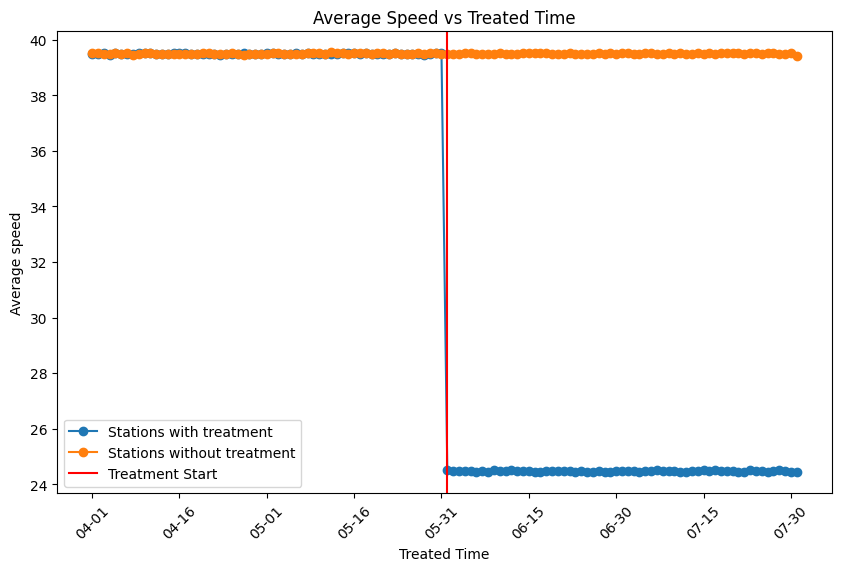

In [140]:
from matplotlib.ticker import MaxNLocator

df_polApp_avg=df_polApp.groupby('treated_time').mean().reset_index()[['treated_time','date','weather','dow','hour','speed','vehicleType','energyConsumption','trafficCongestion','carCrash','pedestrianDeath']]
df_polNA_avg=df_polNA.groupby('treated_time').mean().reset_index()[['treated_time','date','weather','dow','hour','speed','vehicleType','energyConsumption','trafficCongestion','carCrash','pedestrianDeath']]
df_polApp_avg['date_str'] = df_polApp_avg['date'].dt.strftime('%m-%d')
df_polNA_avg['date_str'] = df_polNA_avg['date'].dt.strftime('%m-%d')
treatment_start=df_polApp_avg[df_polApp_avg['treated_time']==0]['date'].iloc[0]
treatment_start_str=treatment_start.strftime('%m-%d')
plt.figure(figsize=(10,6))
plt.plot(df_polApp_avg['date_str'],df_polApp_avg['speed'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['date_str'],df_polNA_avg['speed'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average speed')
plt.title('Average Speed vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()
print("The maximum speed without new policy is:",df_polNA['speed'].max().round())
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['speed'].max().round())

The maximum speed without new policy is: 9.1
The maximum speed with new policy is: 11.2


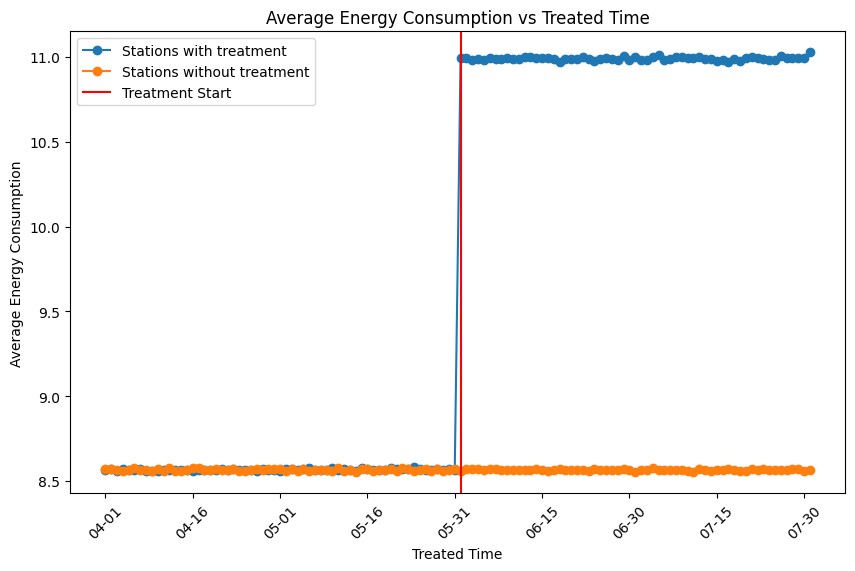

In [141]:
plt.figure(figsize=(10,6))
plt.plot(df_polApp_avg['date_str'],df_polApp_avg['energyConsumption'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['date_str'],df_polNA_avg['energyConsumption'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Energy Consumption')
plt.title('Average Energy Consumption vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()


print("The maximum speed without new policy is:",df_polNA['energyConsumption'].max().round(1))
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['energyConsumption'].max().round(1))

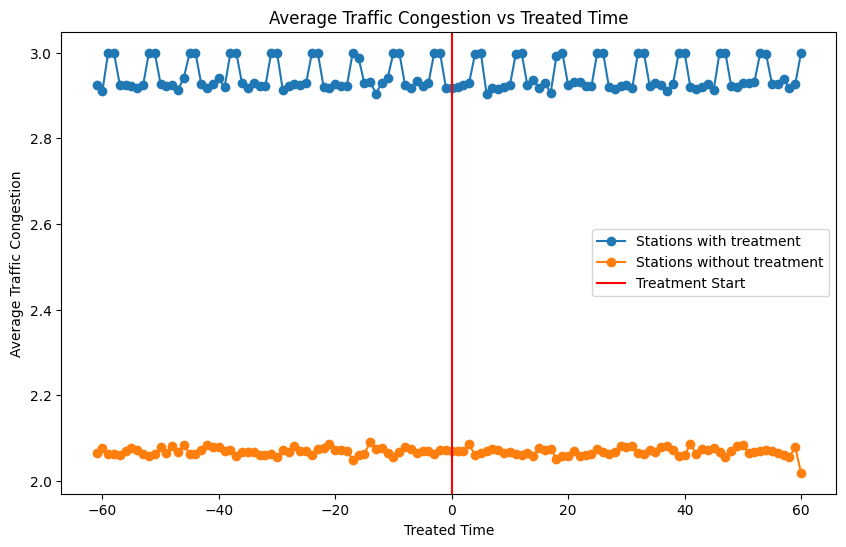

In [142]:
plt.figure(figsize=(10,6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['trafficCongestion'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['trafficCongestion'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Traffic Congestion')
plt.title('Average Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()


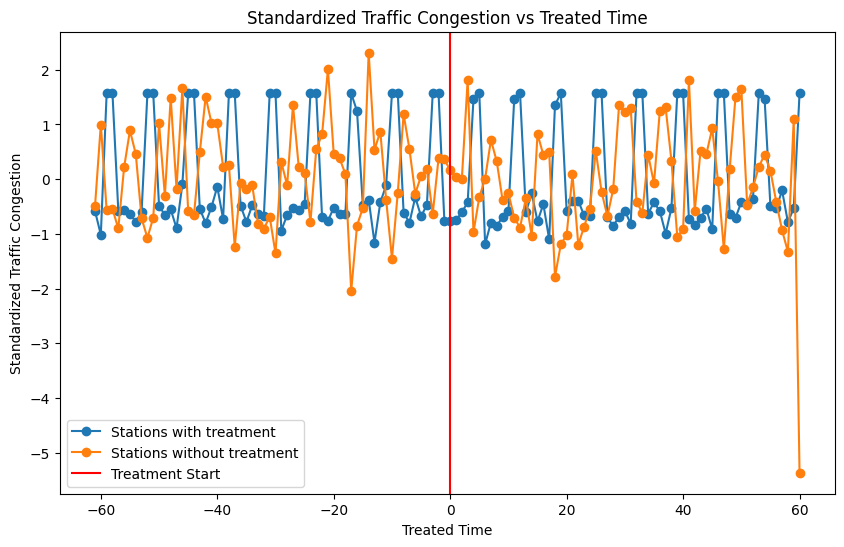

In [143]:
df_polApp_avg["traffic_standardized"] = (df_polApp_avg["trafficCongestion"] - df_polApp_avg["trafficCongestion"].mean()) / df_polApp_avg["trafficCongestion"].std()
df_polNA_avg["traffic_standardized"] = (df_polNA_avg["trafficCongestion"] - df_polNA_avg["trafficCongestion"].mean()) / df_polNA_avg["trafficCongestion"].std()
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['traffic_standardized'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['traffic_standardized'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Standardized Traffic Congestion')
plt.title('Standardized Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [144]:
import statsmodels.formula.api as smf

df_polApp_avg["group"] = 1  # treated
df_polNA_avg["group"] = 0  # control

df_all = pd.concat([df_polApp_avg, df_polNA_avg], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

# Difference-in-Differences regression
model = smf.ols("trafficCongestion ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      trafficCongestion   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.171e+04
Date:                Wed, 07 May 2025   Prob (F-statistic):          4.19e-305
Time:                        00:34:59   Log-Likelihood:                 600.42
No. Observations:                 244   AIC:                            -1181.
Df Residuals:                     234   BIC:                            -1146.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.0586      0

The R^2 of 0.998 implies that the model is pretty accurate, but the group:post DiD coefficient is very close to 0, and more important, the p-value (0.854) is too big, so the treatment didn't actually have an impact in traffic congestion

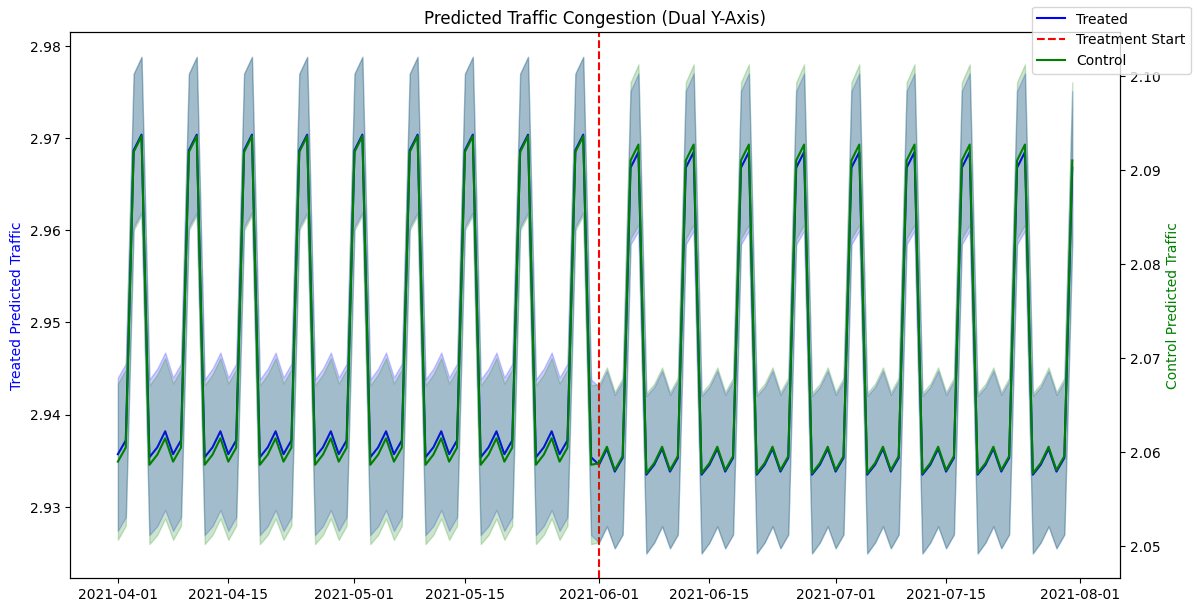

In [145]:
import seaborn as sns

predictions=model.get_prediction(df_all)

df_all['predictedTraffic']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedTraffic', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedTraffic'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Traffic', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedTraffic'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Traffic', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Traffic Congestion (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

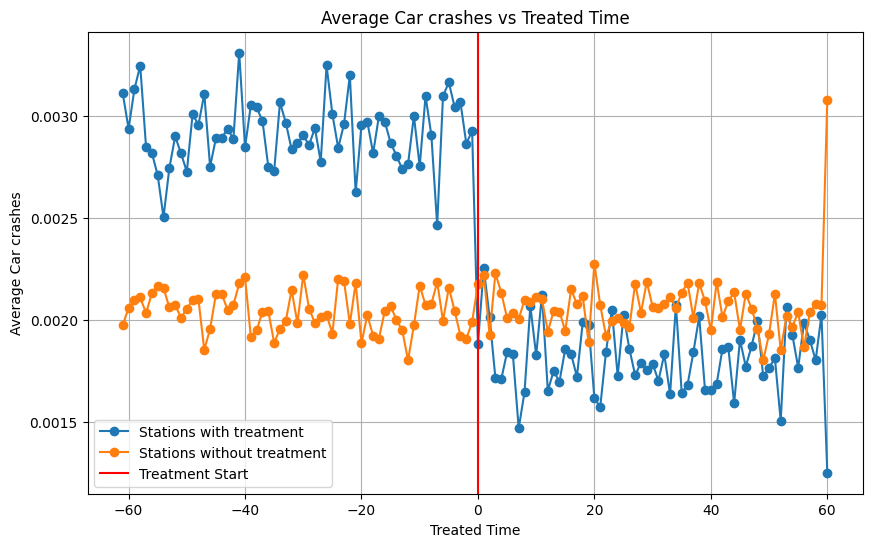

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['carCrash'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['carCrash'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Car crashes')
plt.title('Average Car crashes vs Treated Time')
plt.grid(True)
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [147]:
model = smf.ols("carCrash ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               carCrash   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     205.4
Date:                Wed, 07 May 2025   Prob (F-statistic):          8.66e-106
Time:                        00:35:00   Log-Likelihood:                 1801.6
No. Observations:                 244   AIC:                            -3583.
Df Residuals:                     234   BIC:                            -3548.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0020   3.12

The R^2 of 0.883 implies that the model is pretty accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.000, so the treatment had a big impact in the frequency of car crashes.

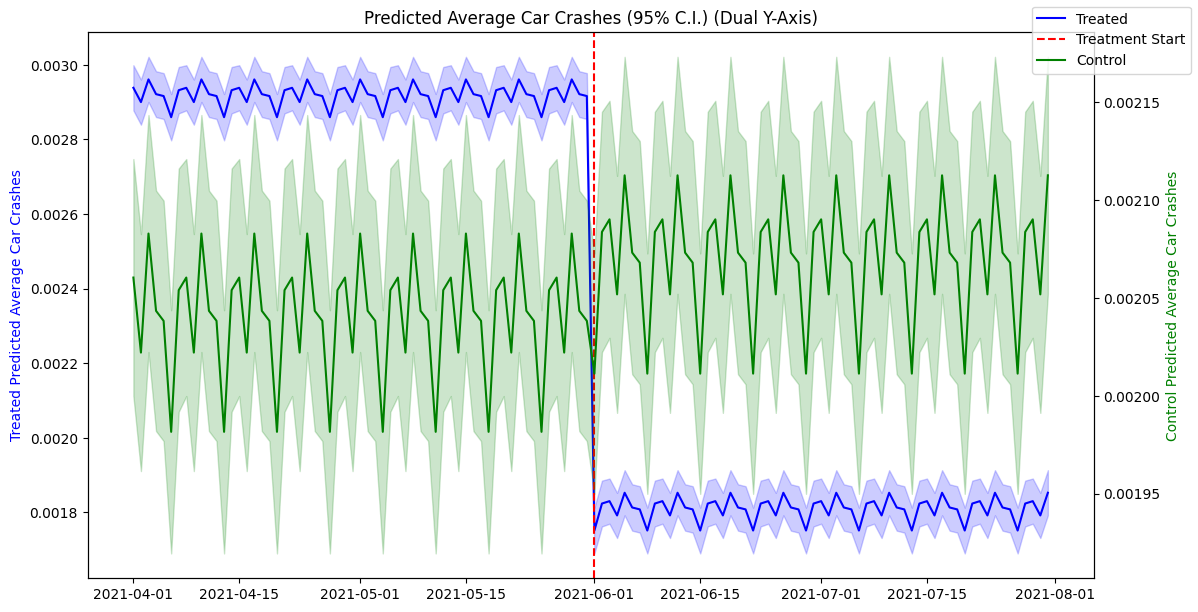

In [148]:
predictions=model.get_prediction(df_all)

df_all['predictedCrashes']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedCrashes', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedCrashes'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Average Car Crashes', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedCrashes'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Average Car Crashes', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Car Crashes (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

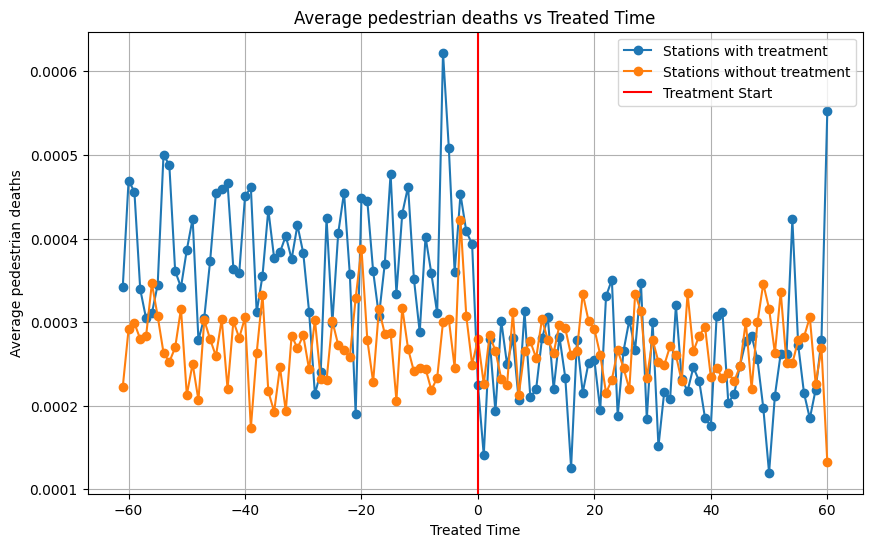

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['pedestrianDeath'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['pedestrianDeath'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average pedestrian deaths')
plt.title('Average pedestrian deaths vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.grid(True)
plt.legend()

In [150]:
model = smf.ols("pedestrianDeath ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        pedestrianDeath   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     22.35
Date:                Wed, 07 May 2025   Prob (F-statistic):           3.32e-27
Time:                        00:35:00   Log-Likelihood:                 2032.5
No. Observations:                 244   AIC:                            -4045.
Df Residuals:                     234   BIC:                            -4010.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0003   1.21

The R^2 of 0.462 implies that the model is decently accurate, and although the group:post DiD coefficient is very close to 0, the p-value (0.00) is lower than 0.000, so the treatment had a clear impact in the frequency of pedestrian deaths.

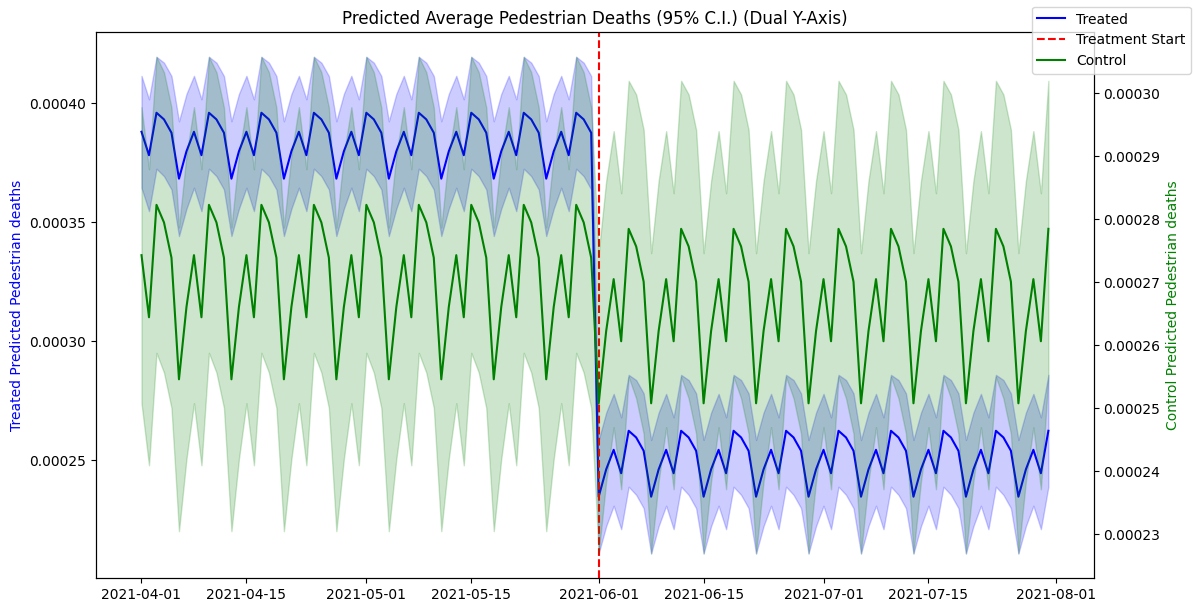

In [151]:
predictions=model.get_prediction(df_all)

df_all['predictedPedestrianDeath']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedPedestrianDeath', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedPedestrianDeath'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Pedestrian deaths', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedPedestrianDeath'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Pedestrian deaths', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Pedestrian Deaths (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

## Here is just full of drafts, so it's not actually part of the project

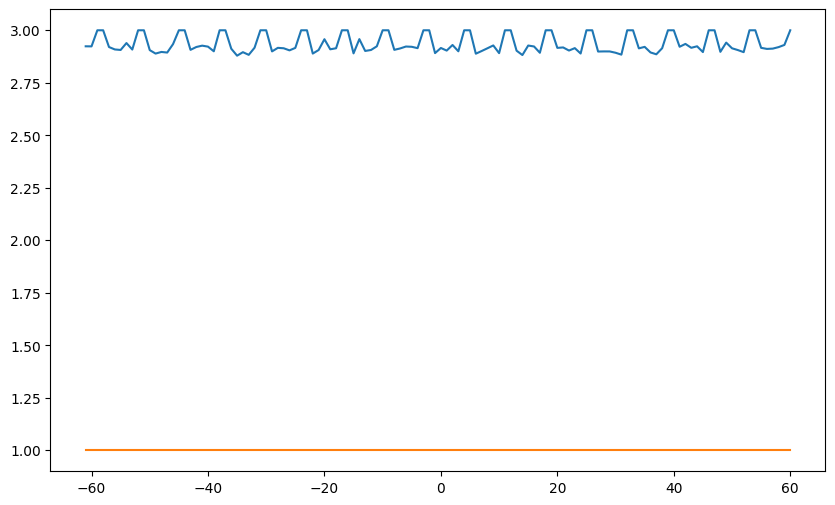

In [152]:
#filtered_df=df[(df['hour']<11) | (df['hour']>15)]
df_1_1=df[(df['city']==1)&(df['station']==10)]#[['trafficCongestion','treated_time']]
df_1_2=df[(df['city']==5)&(df['station']==6)]#[['trafficCongestion','treated_time']]
plt.figure(figsize=(10, 6))
plt.plot(df_1_1["treated_time"], df_1_1["trafficCongestion"])
plt.plot(df_1_2["treated_time"], df_1_2["trafficCongestion"])
#print(filtered_df[['treated','treated_time']])

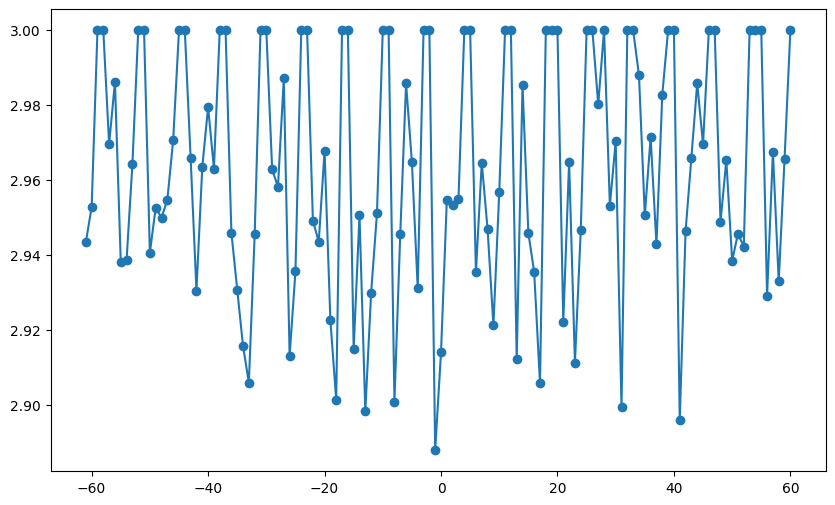

In [153]:
#filtered_df=df[(df['hour']<11) | (df['hour']>15)]
df_1_3=df[(df['city']==1)&(df['station']==4)][['trafficCongestion','treated_time']]
plt.figure(figsize=(10, 6))
plt.plot(df_1_3["treated_time"], df_1_3["trafficCongestion"], marker='o')